In [4]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
# Specify the number of nodes and time step sizes to test
num_nodes_list = [2 ** i for i in range(1, 4)]
dt_list = [2.0 ** -i for i in range(7)]

# Set start and end time
t_start = 0.0
t_end = 1.0
max_iters = 20

# Temporal degree to test higher order time integration
temporal_deg = 20

# Specify if the data should be printed to a file
print_to_file = False
print_file = 'errors.csv'

print("Number of nodes: ", num_nodes_list)
print("Time step sizes: ", dt_list)

Number of nodes:  [2, 4, 8]
Time step sizes:  [1.0, 0.5, 0.25, 0.125, 0.0625, 0.03125, 0.015625]


In [10]:
# Method to execute a simulation with given parameters

##### Test the class #####

from __future__ import print_function, division
from fenics import FunctionSpace, Expression, DirichletBC, VectorFunctionSpace
from errorcomputation import compute_errors
from my_enums import DomainPart
from problem_setup import get_geometry
import sympy as sp

from problem_setup import get_geometry
from my_enums import DomainPart

from pySDC.implementations.sweeper_classes.imex_1st_order_mass import imex_1st_order_mass
from pySDC.implementations.controller_classes.controller_nonMPI import controller_nonMPI

from heat_pySDC_problemClass import fenics_heat_2d

import math as math

from pathlib import Path

################################################################
# Definition of fenics stuff
################################################################

# Get the mesh and ignore boundaries as 
# we are only interested in the monolithic case here
domain_mesh, _, remaining_boundary = get_geometry(DomainPart.FULL)

# Define function space using mesh
V = FunctionSpace(domain_mesh, 'P', 2)
V_g = VectorFunctionSpace(domain_mesh, 'P', 1)
W = V_g.sub(0).collapse()

# Create sympy description of manufactured solution
alpha = 3
beta = 1.2
# temporal_deg specified in above cell

x_sp, y_sp, t_sp = sp.symbols(['x[0]', 'x[1]', 't'])
solution_sp = 1 + x_sp * x_sp + alpha * y_sp * y_sp + beta * (t_sp ** temporal_deg)

# Generate fenics expression for manufactured solution and the forcing term
solution_expr = Expression(sp.ccode(solution_sp), degree=2, alpha=alpha, beta=beta, temporal_deg=temporal_deg, t=0)
forcing_term_expr = Expression(sp.ccode(solution_sp.diff(t_sp) - solution_sp.diff(x_sp).diff(x_sp) - solution_sp.diff(y_sp).diff(y_sp)), degree=2, alpha=alpha, beta=beta, t=0)

################################################################
# Routine to setup a problem and run the simulation
# for a certain number of nodes, time step size,
# start and end time
################################################################
def run_simulation(num_nodes, dt, t_start, t_end, max_iters=20):
    

    # initialize level parameters
    level_params = dict()
    level_params['restol'] = 1e-12
    level_params['dt'] = dt

    # initialize step parameters
    step_params = dict()
    step_params['maxiter'] = max_iters

    # initialize sweeper parameters
    sweeper_params = dict()
    sweeper_params['quad_type'] = 'LOBATTO'
    sweeper_params['num_nodes'] = num_nodes

    # initialize problem parameters
    problem_params = dict()
    problem_params['mesh'] = domain_mesh
    problem_params['function_space'] = V
    problem_params['coupling_boundary'] = None
    problem_params['coupling_expr'] = None
    problem_params['remaining_boundary'] = remaining_boundary
    problem_params['solution_expr'] = solution_expr
    problem_params['forcing_term_expr'] = forcing_term_expr
    problem_params['precice_ref'] = None

    # initialize controller parameters
    controller_params = dict()
    controller_params['logger_level'] = 30

    # fill description dictionary for easy step instantiation
    description = dict()
    description['problem_class'] = fenics_heat_2d
    description['problem_params'] = problem_params
    description['sweeper_class'] = imex_1st_order_mass
    description['sweeper_params'] = sweeper_params
    description['level_params'] = level_params
    description['step_params'] = step_params

    # Controller for time stepping
    controller = controller_nonMPI(num_procs=1, controller_params=controller_params, description=description)

    # Reference to problem class for easy access to exact solution
    P = controller.MS[0].levels[0].prob



    ################################################################
    # Execution of simulation
    ################################################################
    u_init = P.u_exact(t_start)
    u_end, _ = controller.run(u_init, t0=t_start, Tend=t_end)
    u_ref = P.u_exact(t_end)

    # Compute and return the error
    error, _ = compute_errors(u_end.values, u_ref.values, V, 1.0)
    return error

In [11]:
# Run the simulation
###########################################################################################################
# Run simulations with different number of nodes and timesteps to understand convergence
###########################################################################################################
output_data = {}
output_data['dt'] = dt_list

for num_nodes in num_nodes_list:
    print("Run simulation with %d nodes" % num_nodes)
    err_write_curr = []
    err_order_curr = []
    for i, dt in enumerate(dt_list):
        print("|-- Current dt: %.3g" % dt)
        
        error = run_simulation(num_nodes, dt, t_start, t_end, max_iters)
        err_write_curr.append(error)
        
        if i == 0:
            err_order_curr.append(0)
        else:
            err_order_curr.append(math.log(err_write_curr[i-1] / error, dt_list[i-1] / dt_list[i]))        
        
        print("|   |---- L2 error on domain: %.3g" % error)
        print("|")
    output_data[f"{num_nodes}"] = err_write_curr
    output_data[f"{num_nodes}_order"] = err_order_curr
    print()

# Wrap the collected data in a pandas dataframe
df = pd.DataFrame(output_data)

# Print the data to a file if specified
if print_to_file == True:
    dir_path = "heat_pySDC_monolithic_output"
    Path(dir_path).mkdir(exist_ok=True, parents=True)
    err_out_name = dir_path + "/" + print_file
    err_out = open(err_out_name, "w")
    df.to_csv(err_out, index=False)
    print(f"Data written to {err_out_name}")
    err_out.close()


print("Finished running simulations.")


Run simulation with 2 nodes
|-- Current dt: 1
L2 error on domain = 2.14e+03
|   |---- L2 error on domain: 2.14e+03
|
|-- Current dt: 0.5
L2 error on domain = 0.287
|   |---- L2 error on domain: 0.287
|
|-- Current dt: 0.25
L2 error on domain = 0.184
|   |---- L2 error on domain: 0.184
|
|-- Current dt: 0.125
L2 error on domain = 0.0793
|   |---- L2 error on domain: 0.0793
|
|-- Current dt: 0.0625
L2 error on domain = 0.0246
|   |---- L2 error on domain: 0.0246
|
|-- Current dt: 0.0312
L2 error on domain = 0.0066
|   |---- L2 error on domain: 0.0066
|
|-- Current dt: 0.0156
L2 error on domain = 0.00169
|   |---- L2 error on domain: 0.00169
|

Run simulation with 4 nodes
|-- Current dt: 1
L2 error on domain = 1.67e+03
|   |---- L2 error on domain: 1.67e+03
|
|-- Current dt: 0.5
L2 error on domain = 0.0452
|   |---- L2 error on domain: 0.0452
|
|-- Current dt: 0.25
L2 error on domain = 0.0049
|   |---- L2 error on domain: 0.0049
|
|-- Current dt: 0.125
L2 error on domain = 0.000235
|   |-

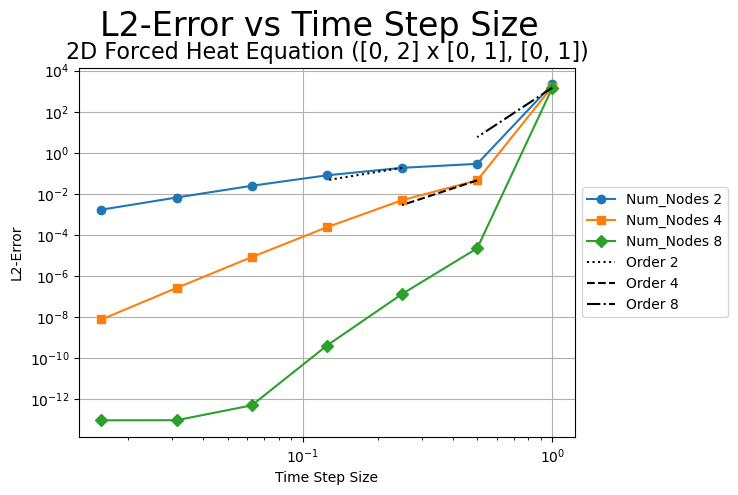

In [12]:
# Plot the collected data
if print_to_file == True:
    dir_path = "heat_pySDC_monolithic_output"
    file_path = f"{dir_path}/{print_file}"
    df = pd.read_csv(file_path)


fig, ax = plt.subplots()

x = 'dt'
y_arr = [f"{num_nodes}" for num_nodes in num_nodes_list]
labels = [f"Num_Nodes {num_nodes}" for num_nodes in num_nodes_list]
markers = ['o', 's', 'D', '^']
for (y, label, marker) in zip(y_arr, labels, markers):
    df.plot(x=x, y=y, label=label, marker=marker, ax=ax)

fig.suptitle('L2-Error vs Time Step Size', fontsize=24, y=1)
ax.set_title('2D Forced Heat Equation ([0, 2] x [0, 1], [0, 1])', fontsize=16)
ax.set_xlabel('Time Step Size')
ax.set_ylabel('L2-Error')
ax.set_xscale('log', base=2)
ax.set_yscale('log', base=10)


# Plot order guides into the plot

# Set expected orders for guides
# The expected order is the number of nodes + 1
expected_orders = [num_nodes for num_nodes in num_nodes_list]
linestyles = ['dotted', 'dashed', 'dashdot', 'solid']

for i, num_nodes in enumerate(num_nodes_list):
    dt_list_adjusted = dt_list[len(num_nodes_list) - i - 1:len(num_nodes_list) - i + 1]
    order = expected_orders[i]
    base_error = df[f"{num_nodes}"][len(num_nodes_list) - i - 1]
    order_guide = [base_error / (2 ** (order*i)) for i in range(0, len(dt_list_adjusted))]
    ax.loglog(dt_list_adjusted, order_guide, color='black', linestyle=linestyles[i], label=f"Order {order}")
    
# Add legend on bottom left
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Add grid
ax.grid()